In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from prophet import Prophet
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import pygsheets
from google.oauth2.service_account import Credentials
from oauth2client.service_account import ServiceAccountCredentials
from tqdm import tqdm
from time import time



# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Multi-processing
from multiprocessing import Pool, cpu_count

# Spark
from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf, PandasUDFType

import sqlalchemy as db
from sqlalchemy import create_engine
import mysql.connector
import psycopg2
import pandas_gbq

In [2]:
# GBQ logging
import logging
logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

In [3]:
credentials = Credentials.from_service_account_file('C:/Users/leemn/Documents/Service Account/bright-arc-328707-173b23869758.json')

In [4]:
start_date = '2014-01-02'
end_date = pd.to_datetime("today").strftime("%Y-%m-%d")   

In [25]:
# Download data
ticker_list = ['CLS.JO', 'GLN.JO', 'PPH.JO','WHL.JO','APN.JO','RBP.JO','PIK.JO',
              'HIL.JO','SOL.JO','EXX.JO','MCG.JO','AIL.JO','TGA.JO','SSW.JO']
data = yf.download(ticker_list, start=start_date, end=end_date)[['Close']]


data.columns = data.columns.droplevel()
data = data/100
data.head()

[*********************100%***********************]  14 of 14 completed


,AIL.JO,APN.JO,CLS.JO,EXX.JO,GLN.JO,HIL.JO,MCG.JO,PIK.JO,PPH.JO,RBP.JO,SOL.JO,SSW.JO,TGA.JO,WHL.JO
Date,,,,,,,,,,,,,,
2014-01-02,NaN,273.05,62.80,150.00,54.09,NaN,NaN,52.10,NaN,54.686572,517.04,NaN,NaN,72.086157
2014-01-03,NaN,273.53,62.90,151.98,53.49,NaN,NaN,52.00,NaN,54.714399,516.11,NaN,NaN,71.029287
2014-01-06,NaN,268.01,62.03,150.81,53.64,NaN,NaN,51.21,NaN,54.538169,516.10,NaN,NaN,69.981938
2014-01-07,NaN,270.89,61.86,150.00,53.70,NaN,NaN,50.60,NaN,53.657026,521.05,NaN,NaN,70.239014
2014-01-08,NaN,269.61,60.71,150.83,55.67,NaN,NaN,50.50,NaN,53.490073,517.68,NaN,NaN,68.801289


In [26]:
data.tail()

,AIL.JO,APN.JO,CLS.JO,EXX.JO,GLN.JO,HIL.JO,MCG.JO,PIK.JO,PPH.JO,RBP.JO,SOL.JO,SSW.JO,TGA.JO,WHL.JO
Date,,,,,,,,,,,,,,
2022-08-19,5.95,147.43,301.75,213.59,97.90,27.00,120.20,61.30,20.55,144.20,331.36,38.29,325.05,53.19
2022-08-22,5.90,149.11,306.20,222.22,98.12,27.00,120.99,62.21,20.33,143.01,331.96,38.54,336.03,53.00
2022-08-23,5.78,145.79,303.85,226.20,101.10,26.95,120.33,62.00,20.34,146.00,338.26,39.67,348.98,52.92
2022-08-24,5.80,140.91,303.38,223.28,100.08,27.00,119.44,62.19,20.24,144.90,349.84,39.64,352.86,52.34
2022-08-25,5.80,144.41,302.22,225.57,100.20,25.00,118.21,62.11,20.37,146.80,355.64,41.14,348.10,53.51


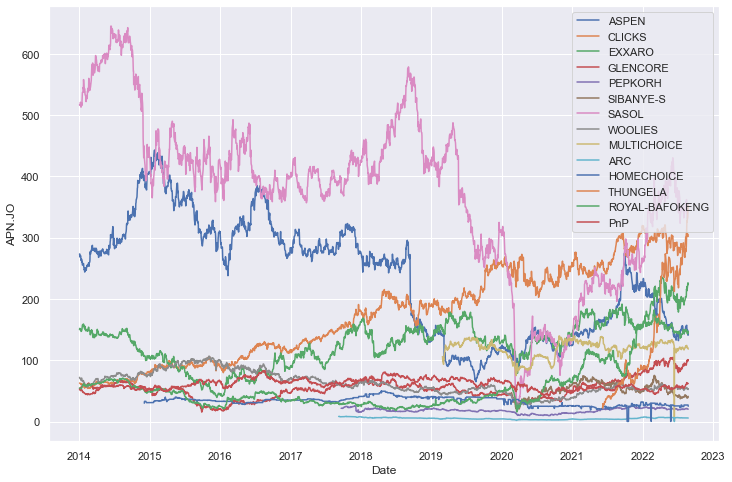

In [27]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=data.index, y=data['APN.JO'])
sns.lineplot(x=data.index, y=data['CLS.JO'])
sns.lineplot(x=data.index, y=data['EXX.JO'])
sns.lineplot(x=data.index, y=data['GLN.JO'])
sns.lineplot(x=data.index, y=data['PPH.JO'])
sns.lineplot(x=data.index, y=data['SSW.JO'])
sns.lineplot(x=data.index, y=data['SOL.JO'])
sns.lineplot(x=data.index, y=data['WHL.JO'])
sns.lineplot(x=data.index, y=data['MCG.JO'])
sns.lineplot(x=data.index, y=data['AIL.JO'])
sns.lineplot(x=data.index, y=data['HIL.JO'])
sns.lineplot(x=data.index, y=data['TGA.JO'])
sns.lineplot(x=data.index, y=data['RBP.JO'])
sns.lineplot(x=data.index, y=data['PIK.JO'])
plt.legend(labels = ['ASPEN','CLICKS', 'EXXARO','GLENCORE','PEPKORH','SIBANYE-S',
                     'SASOL','WOOLIES','MULTICHOICE','ARC','HOMECHOICE','THUNGELA','ROYAL-BAFOKENG','PnP'])

In [28]:
# Release Date from the index
data = data.reset_index()

# Change data from the wide format to the long format
df = pd.melt(data, id_vars='Date', value_vars=['CLS.JO', 'GLN.JO', 'PPH.JO','WHL.JO','APN.JO','RBP.JO','PIK.JO',
                                               'HIL.JO','SOL.JO','EXX.JO','MCG.JO','AIL.JO','TGA.JO','SSW.JO'])
df.columns = ['ds', 'ticker', 'y']
df.head()

,ds,ticker,y
0,2014-01-02,CLS.JO,62.80
1,2014-01-03,CLS.JO,62.90
2,2014-01-06,CLS.JO,62.03
3,2014-01-07,CLS.JO,61.86
4,2014-01-08,CLS.JO,60.71


In [29]:
df['ticker'].unique(), df['ticker'].nunique()

(array(['CLS.JO', 'GLN.JO', 'PPH.JO', 'WHL.JO', 'APN.JO', 'RBP.JO',
        'PIK.JO', 'HIL.JO', 'SOL.JO', 'EXX.JO', 'MCG.JO', 'AIL.JO',
        'TGA.JO', 'SSW.JO'], dtype=object),
 14)

## Train Prophet model

In [30]:
# Group the data by ticker
groups_by_ticker = df.groupby('ticker')
# Check the groups in the dataframe
groups_by_ticker.groups.keys()

dict_keys(['AIL.JO', 'APN.JO', 'CLS.JO', 'EXX.JO', 'GLN.JO', 'HIL.JO', 'MCG.JO', 'PIK.JO', 'PPH.JO', 'RBP.JO', 'SOL.JO', 'SSW.JO', 'TGA.JO', 'WHL.JO'])

In [31]:
def train_and_forecast(group):
    m = Prophet(interval_width = 0.95)
    m.fit(group)
    future = m.make_future_dataframe(periods = 465)
    forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    forecast['ticker'] = group['ticker'].iloc[0]
  
    return forecast[['ds', 'ticker', 'yhat', 'yhat_upper', 'yhat_lower']]

In [33]:
start_time = time()

ticker_list = ['CLS.JO', 'GLN.JO', 'PPH.JO','WHL.JO','APN.JO','RBP.JO','PIK.JO',
               'HIL.JO','SOL.JO','EXX.JO','MCG.JO','AIL.JO','TGA.JO','SSW.JO']

for_loop_forecast = pd.DataFrame()

# Loop through each ticker
for ticker in ticker_list:
    group = groups_by_ticker.get_group(ticker)  
    forecast = train_and_forecast(group)
    for_loop_forecast = pd.concat((for_loop_forecast, forecast))
print('The time used for the for-loop forecast is ', time()-start_time)

23:23:24 - cmdstanpy - INFO - Chain [1] start processing
23:23:24 - cmdstanpy - INFO - Chain [1] done processing
23:23:27 - cmdstanpy - INFO - Chain [1] start processing
23:23:27 - cmdstanpy - INFO - Chain [1] done processing
23:23:29 - cmdstanpy - INFO - Chain [1] start processing
23:23:29 - cmdstanpy - INFO - Chain [1] done processing
23:23:31 - cmdstanpy - INFO - Chain [1] start processing
23:23:32 - cmdstanpy - INFO - Chain [1] done processing
23:23:34 - cmdstanpy - INFO - Chain [1] start processing
23:23:34 - cmdstanpy - INFO - Chain [1] done processing
23:23:37 - cmdstanpy - INFO - Chain [1] start processing
23:23:37 - cmdstanpy - INFO - Chain [1] done processing
23:23:39 - cmdstanpy - INFO - Chain [1] start processing
23:23:39 - cmdstanpy - INFO - Chain [1] done processing
23:23:41 - cmdstanpy - INFO - Chain [1] start processing
23:23:42 - cmdstanpy - INFO - Chain [1] done processing
23:23:44 - cmdstanpy - INFO - Chain [1] start processing
23:23:45 - cmdstanpy - INFO - Chain [1]

The time used for the for-loop forecast is  34.276611328125


In [34]:
for_loop_forecast['ticker'].unique()

array(['CLS.JO', 'GLN.JO', 'PPH.JO', 'WHL.JO', 'APN.JO', 'RBP.JO',
       'PIK.JO', 'HIL.JO', 'SOL.JO', 'EXX.JO', 'MCG.JO', 'AIL.JO',
       'TGA.JO', 'SSW.JO'], dtype=object)

In [41]:
# give the tickers clear names
for_loop_forecast['ticker_name'] = np.where(for_loop_forecast['ticker']=='CLS.JO','Clicks',
                                  (np.where(for_loop_forecast['ticker']=='GLN.JO','Glencore',
                                  (np.where(for_loop_forecast['ticker']=='PPH.JO','Pepkorh',         
                                  (np.where(for_loop_forecast['ticker']=='WHL.JO','Woolies',        
                                  (np.where(for_loop_forecast['ticker']=='APN.JO','Aspen',  
                                  (np.where(for_loop_forecast['ticker']=='RBP.JO','Royal-Bafokeng',  
                                  (np.where(for_loop_forecast['ticker']=='PIK.JO','PnP',          
                                  (np.where(for_loop_forecast['ticker']=='HIL.JO','HomeChoice',
                                  (np.where(for_loop_forecast['ticker']=='SOL.JO','Sasol',
                                  (np.where(for_loop_forecast['ticker']=='EXX.JO','Exxaro',
                                  (np.where(for_loop_forecast['ticker']=='MCG.JO','MultiChoice',
                                  (np.where(for_loop_forecast['ticker']=='AIL.JO','African-Rainbow',
                                  (np.where(for_loop_forecast['ticker']=='TGA.JO','Thungela',
                                  (np.where(for_loop_forecast['ticker']=='SSW.JO','Sibanye-Stillwater',
                                  for_loop_forecast.ticker)))))))))))))))))))))))))))
for_loop_forecast.tail()

,ds,ticker,yhat,yhat_upper,yhat_lower,ticker_name
2661,2023-11-29,SSW.JO,-10.602062,25.867173,-50.644931,Sibanye-Stillwater
2662,2023-11-30,SSW.JO,-10.704017,27.036287,-50.603409,Sibanye-Stillwater
2663,2023-12-01,SSW.JO,-10.941669,26.547879,-50.375020,Sibanye-Stillwater
2664,2023-12-02,SSW.JO,7.021529,44.998566,-32.097940,Sibanye-Stillwater
2665,2023-12-03,SSW.JO,6.901160,45.817429,-32.803905,Sibanye-Stillwater


In [42]:
# Push predictions to Google sheets

file = 'C:/Users/leemn/Documents/Service Account/bright-arc-328707-173b23869758.json'
id = '1wu6wT8GwPitzhY8Yov3FspFBTd2dC6znKKNcbwP70UQ'
s_n = 'share_price_forecast'


def write_to_gsheet(service_file_path, spreadsheet_id, sheet_name, data_df):
    gc = pygsheets.authorize(service_file=service_file_path)
    sh = gc.open_by_key(spreadsheet_id)
    try:
        sh.add_worksheet(sheet_name)
    except:
        pass
    wks_write = sh.worksheet_by_title(sheet_name)
    wks_write.clear('A1',None,'*')
    wks_write.set_dataframe(data_df, (1,1), encoding='utf-8', fit=True)
    wks_write.frozen_rows = 1

write_to_gsheet(file, id, s_n, for_loop_forecast)

In [43]:
# Push predictions to BigQuery
for_loop_forecast.to_gbq(destination_table='bright-arc-328707.test.stock_price_predictions',
               project_id='bright-arc-328707',
               credentials=credentials,
               chunksize=100000,
               progress_bar=True,
               if_exists='replace')

37324 out of 37324 rows loaded.?it/s]
100%|██████████| 1/1 [00:00<?, ?it/s]
